# The purpose of this script is to run a two disclination simulation wherein the main numerical programs have been compiled by numba. This is supposed to speed up 

### Add path to source files

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'src'))

### If not already created, make save folder for figures

In [2]:
save_folder = r'two-disclination-compiled-simulation-figures'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

### Import necessary libraries, import loading bars, make plots big

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import FiniteDifferenceCompiled as fd
import LiquidCrystalHelperCompiled as lch

from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

import time
import timeit
from importlib import reload

import ipywidgets as widgets
from IPython.display import display
from IPython.display import Video
from IPython.display import Image

In [4]:
reload(fd)
reload(lch)

<module 'LiquidCrystalHelperCompiled' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHydrodynamics\\src\\LiquidCrystalHelperCompiled.py'>

In [5]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

### Define domain, create initial auxiliary variable states for configuation

In [7]:
l = 10
n = 513

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

### Run forward euler scheme with step size `dt` and `num_steps` steps

In [8]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = 15000
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks = lch.findMinima(lambda_max)
    if len(peaks[0]) <= 2:
        peak_pos[:, i] = X[peaks]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=15000)

Simulation ran in 4.616515410000001 minutes.


### Plot peak position vs. time

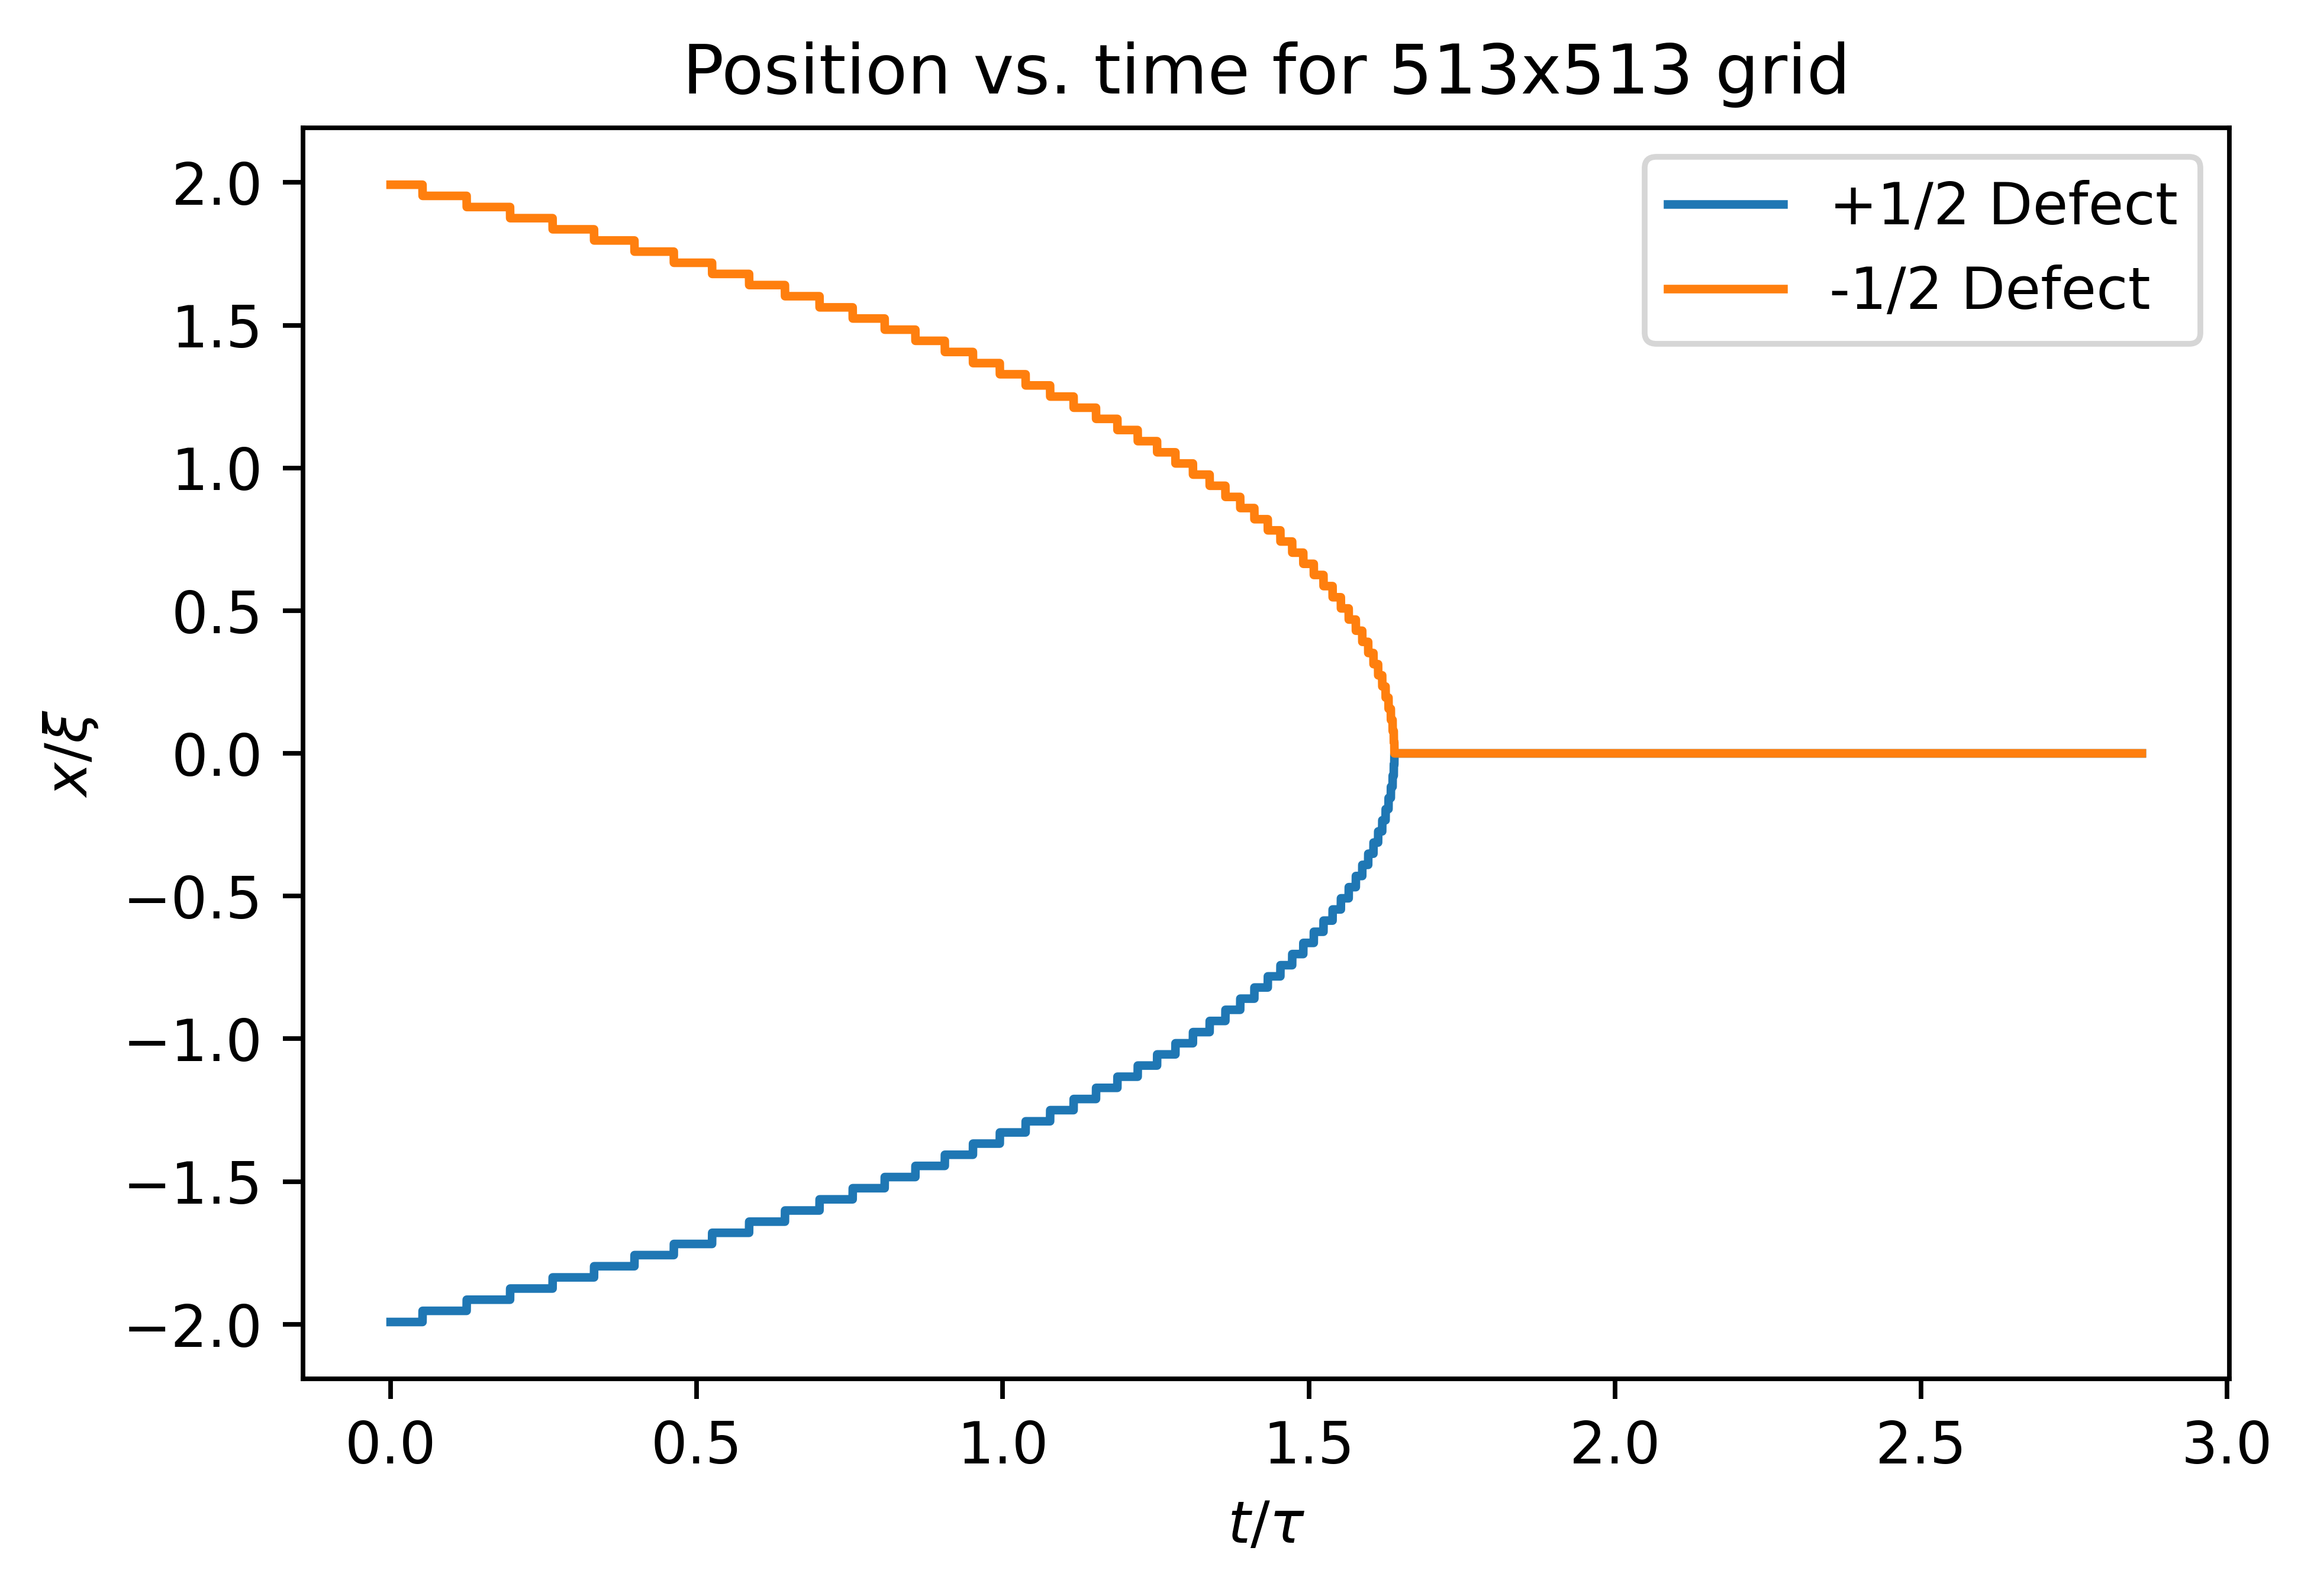

In [10]:
plt.plot(t[:], peak_pos[0, :], label='+1/2 Defect')
plt.plot(t[:], peak_pos[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 513x513 grid')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-513pts.png')
plt.savefig(filename_defect_pos_vs_time)

### Plot difference between consecutive gridpoints to check how big the jumps are

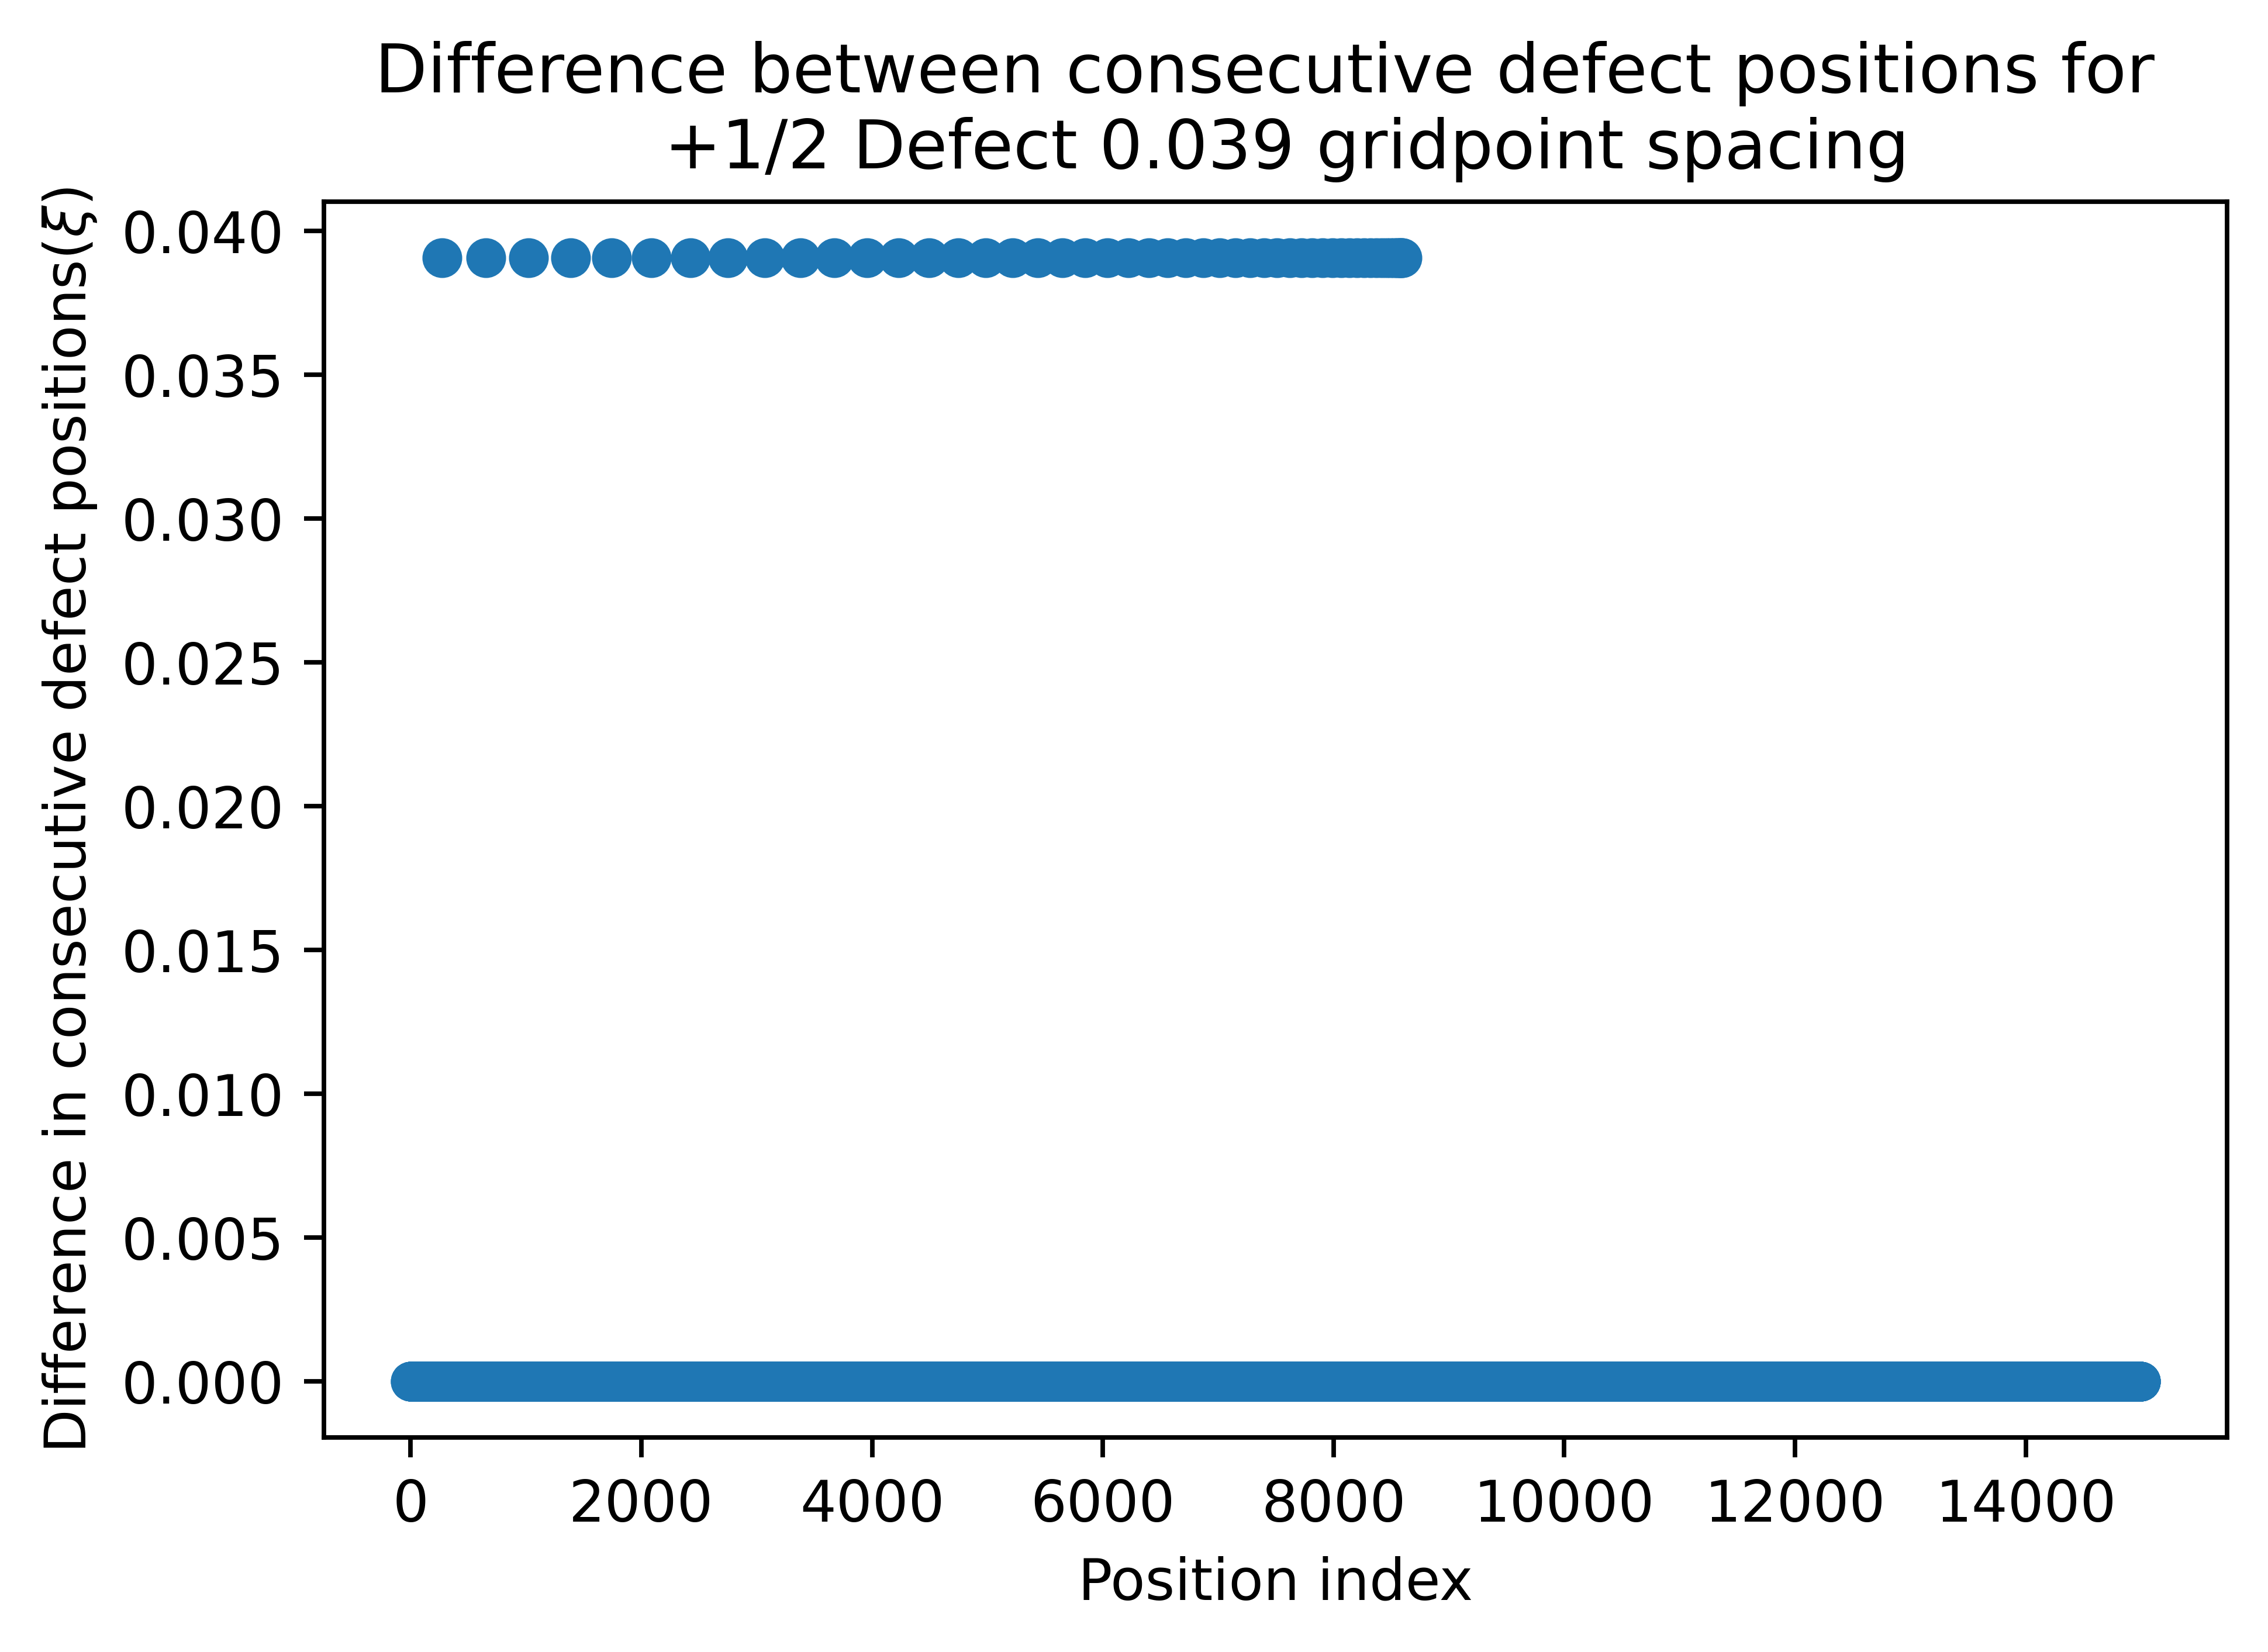

In [11]:
plt.plot(np.diff(peak_pos[0, :]), marker='o', ls='')

plt.title('Difference between consecutive defect positions for \n +1/2 Defect ' + str(round(2*l/n, 4)) + ' gridpoint spacing')
plt.ylabel(r'Difference in consecutive defect positions($\xi$)')
plt.xlabel('Position index')

filename_defect_pos_diffs = os.path.join(save_folder, r'defect-pos-diffs-600pts.png')
plt.savefig(filename_defect_pos_diffs)

### Find if the -1/2 defect ever hits zero

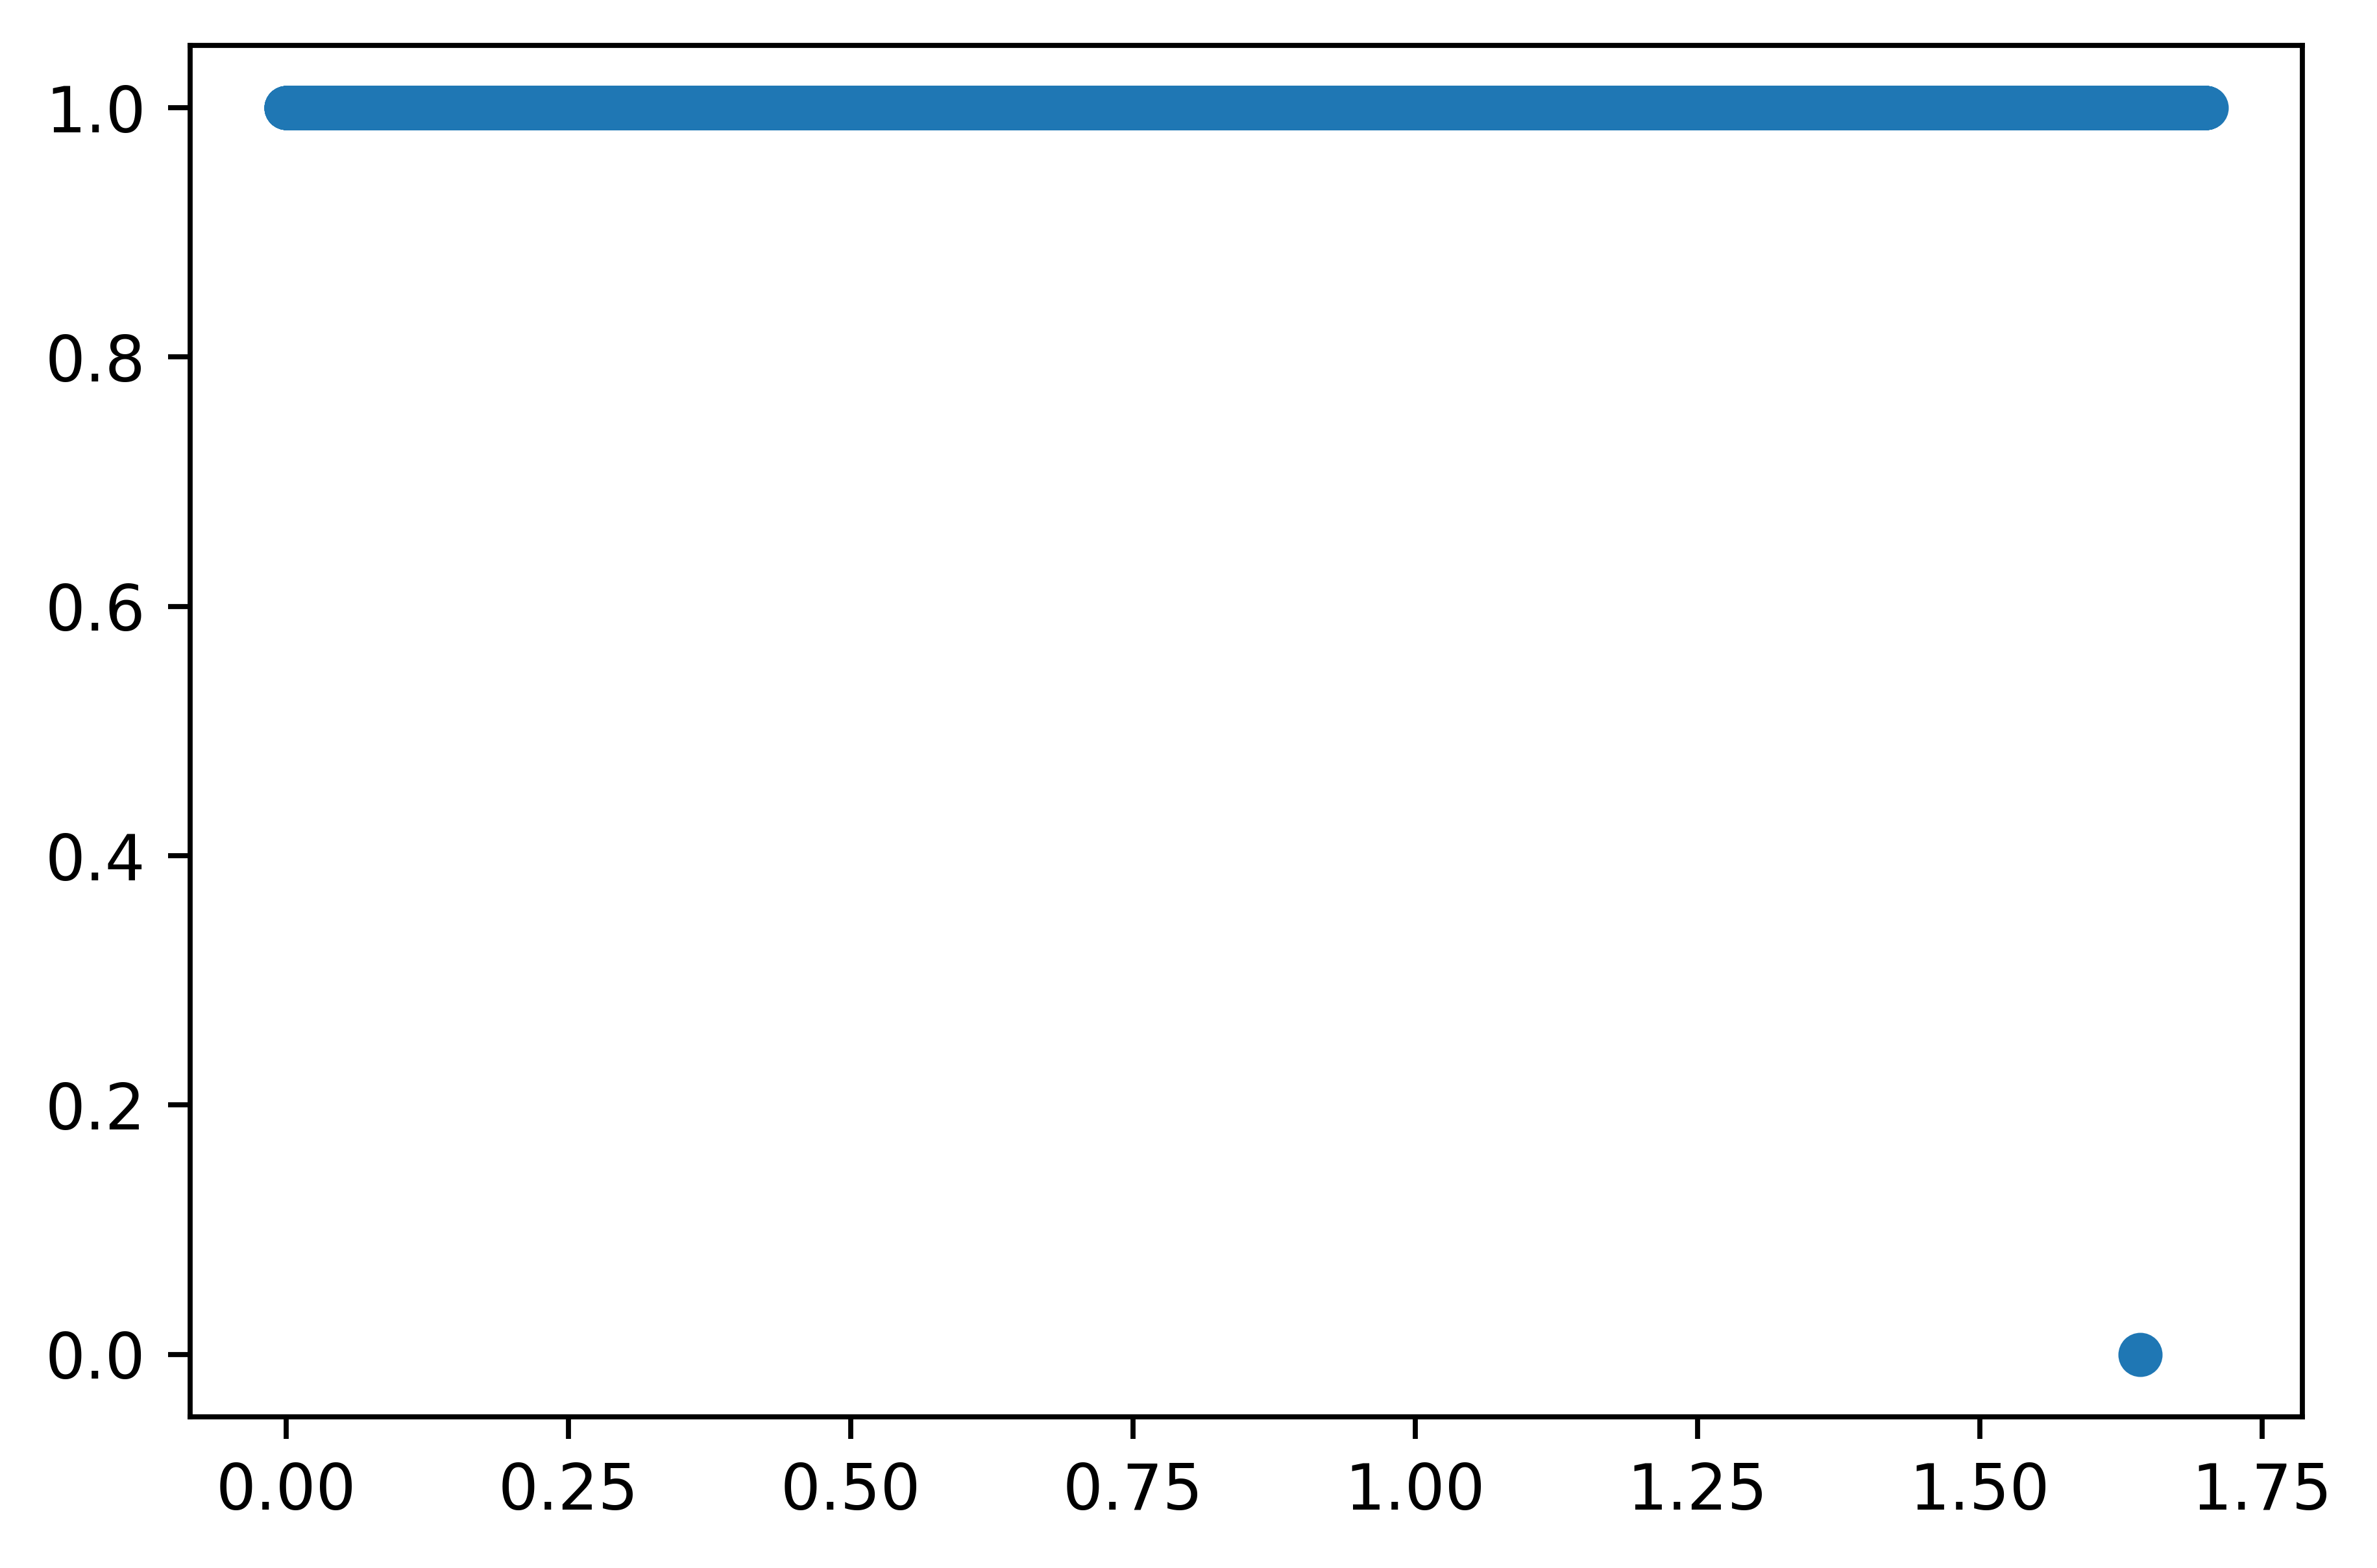

In [10]:
peak_pos_positive = peak_pos[1, :] > 0
plt.plot(t, peak_pos_positive, marker='o', ls='')

### Find first point at which position dips below zero, truncate after that point

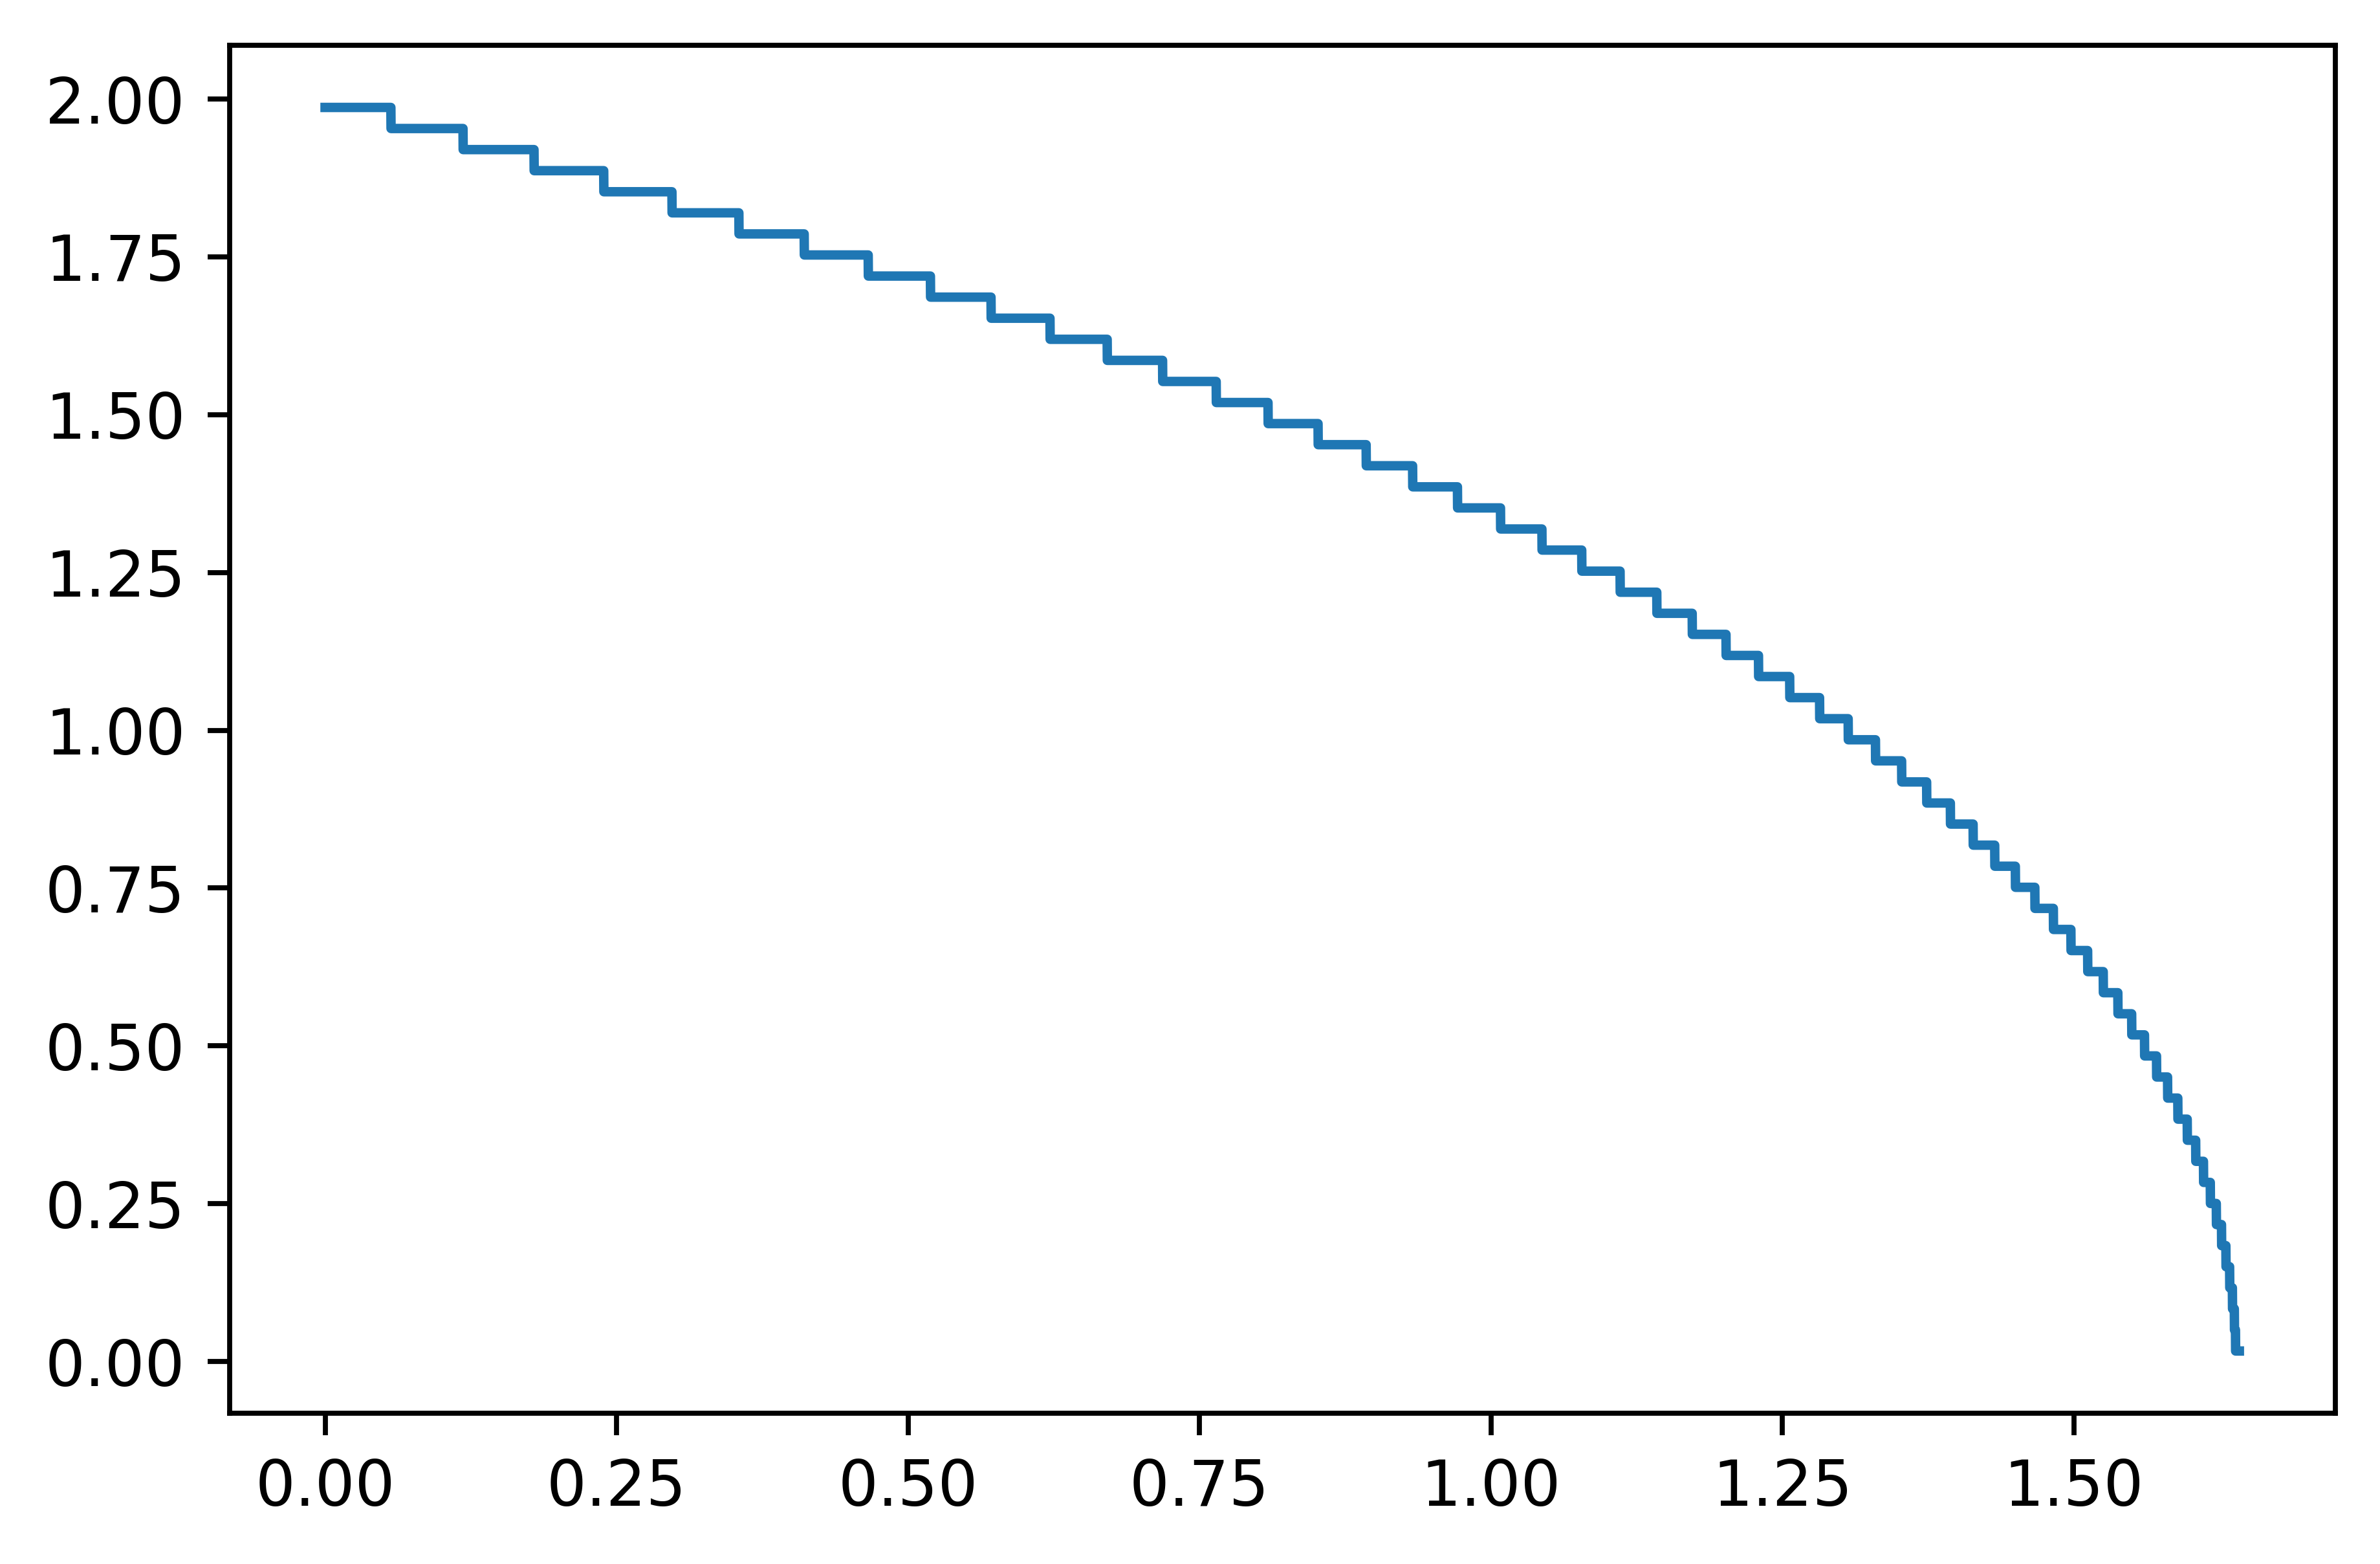

In [11]:
defect_not_positive_idx = np.where(peak_pos[1, :] <= 0)[0]
first_not_positive_idx = defect_not_positive_idx[0]
trunc_pos = peak_pos[1, :first_not_positive_idx]
trunc_t = t[:first_not_positive_idx]

plt.plot(trunc_t, trunc_pos)

### Fit that curve to a square root function (use parabola and reverse arguments/reflect data over axis)

In [12]:
from scipy.optimize import curve_fit

In [13]:
def f(x, a, b, c):
    return a*(x - b)**2 + c

In [14]:
trunc_pos_ref = np.hstack((trunc_pos, -trunc_pos[::-1]))
trunc_t_ref = np.hstack((trunc_t, trunc_t[::-1]))

In [15]:
popt, pcov = curve_fit(f, trunc_pos_ref, trunc_t_ref)

a = popt[0]
b = popt[1]
c = popt[2]

C:\Users\lucas\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


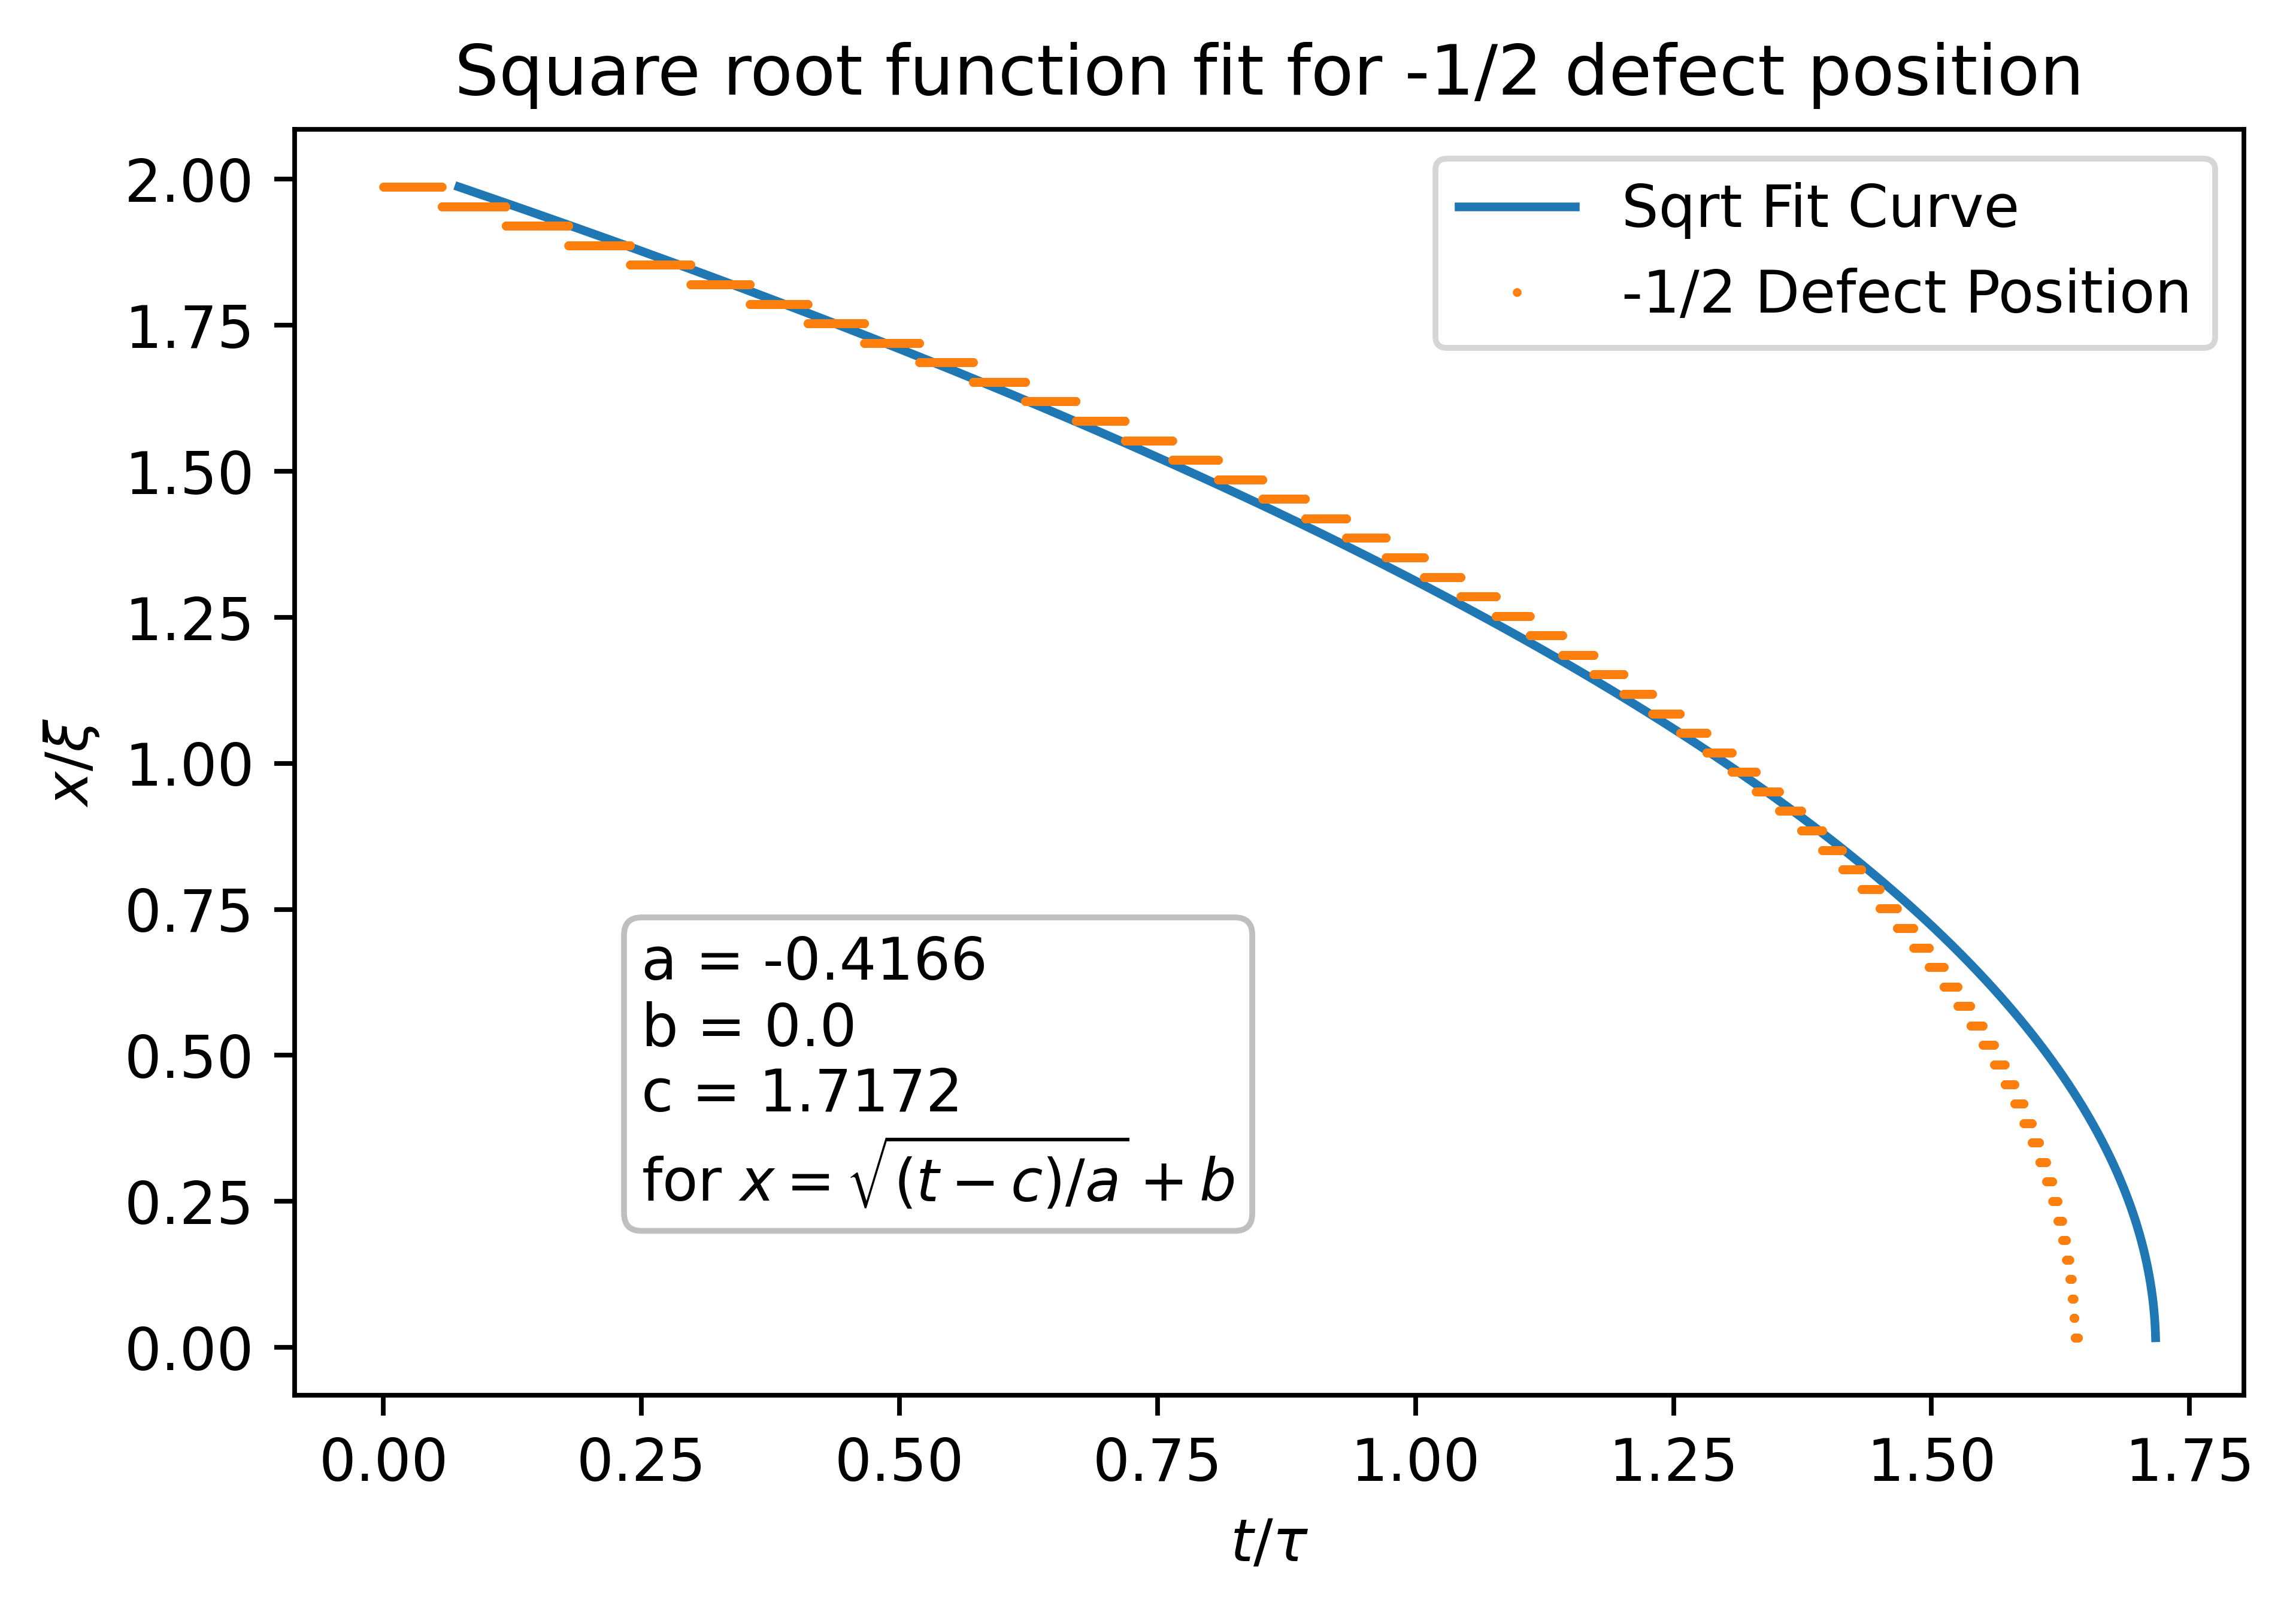

In [34]:
fit_pos = np.linspace(trunc_pos[0], trunc_pos[-1], num=1000)
fit_t = f(fit_pos, a, b, c)
plot_text = ( "a = " + str(round(a, 4)) + "\n"
              + "b = " + str(round(b, 4)) + "\n"
              + "c = " + str(round(c, 4)) + "\n"
              + r"for $x = \sqrt{(t - c)/a} + b$" )

fig, ax = plt.subplots()
ax.plot(fit_t, fit_pos, label='Sqrt Fit Curve')
ax.plot(trunc_t, trunc_pos, marker='o', ls='', ms=.5, label='-1/2 Defect Position')
ax.text(0.25, 0.25, plot_text,
        bbox=dict(boxstyle="round",
                  fc=(1, 1, 1),
                  ec=(.75, .75, .75)))
ax.legend()

ax.set_title('Square root function fit for -1/2 defect position')
ax.set_xlabel(r'$t/\tau$')
ax.set_ylabel(r'$x/\xi$')

filename_sqrt_fit = os.path.join(save_folder, r'sqrt-fit-600pts.png')
fig.savefig(filename_sqrt_fit)

## Calculate how long it would take for defects to annihilate given larger spacing

* y-intercept is at $t = 0$. 
* This will be equal to starting displacement.
* This means $x_0 = \sqrt{-c/a}$.
* Assume only $c$ changes so that the whole thing is shifted around. 
* Given some new $c' = -ax_0^2$ we want to find $t_f$ such that $0 = \sqrt{(t_f - c')/a}$.
* This gives $t_f = c'$. 
* Hence, $t_f = -ax_0^2$.
* Translating that into $n$ number of steps with $dt$ width gives $n = -ax_0^2/dt$. 
* Finally, define a constant $\alpha \equiv T/n$ where $T$ is computational time.
* From previous runs with this size we find $\alpha \approx 4.6/15000 \approx 3.1e-4$. 
* Finally, we get $T = -\alpha a x_0^2/dt$

In [14]:
a = -0.4166
alpha = 3.1e-4

l = 12
n = 513
x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S_val = 0.5
ctr = [[-4, 0], [4, 0]]
r = [1, 1]
m = [-1/2, 1/2]
S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = np.ceil(-a*ctr[1][0]**2/dt).astype(np.int)
comp_time = alpha*num_steps

print(comp_time)

In [17]:
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks = lch.findMinima(lambda_max)
    if len(peaks[0]) <= 2:
        peak_pos[:, i] = X[peaks]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=24269)

Simulation ran in 7.257715791666669 minutes.


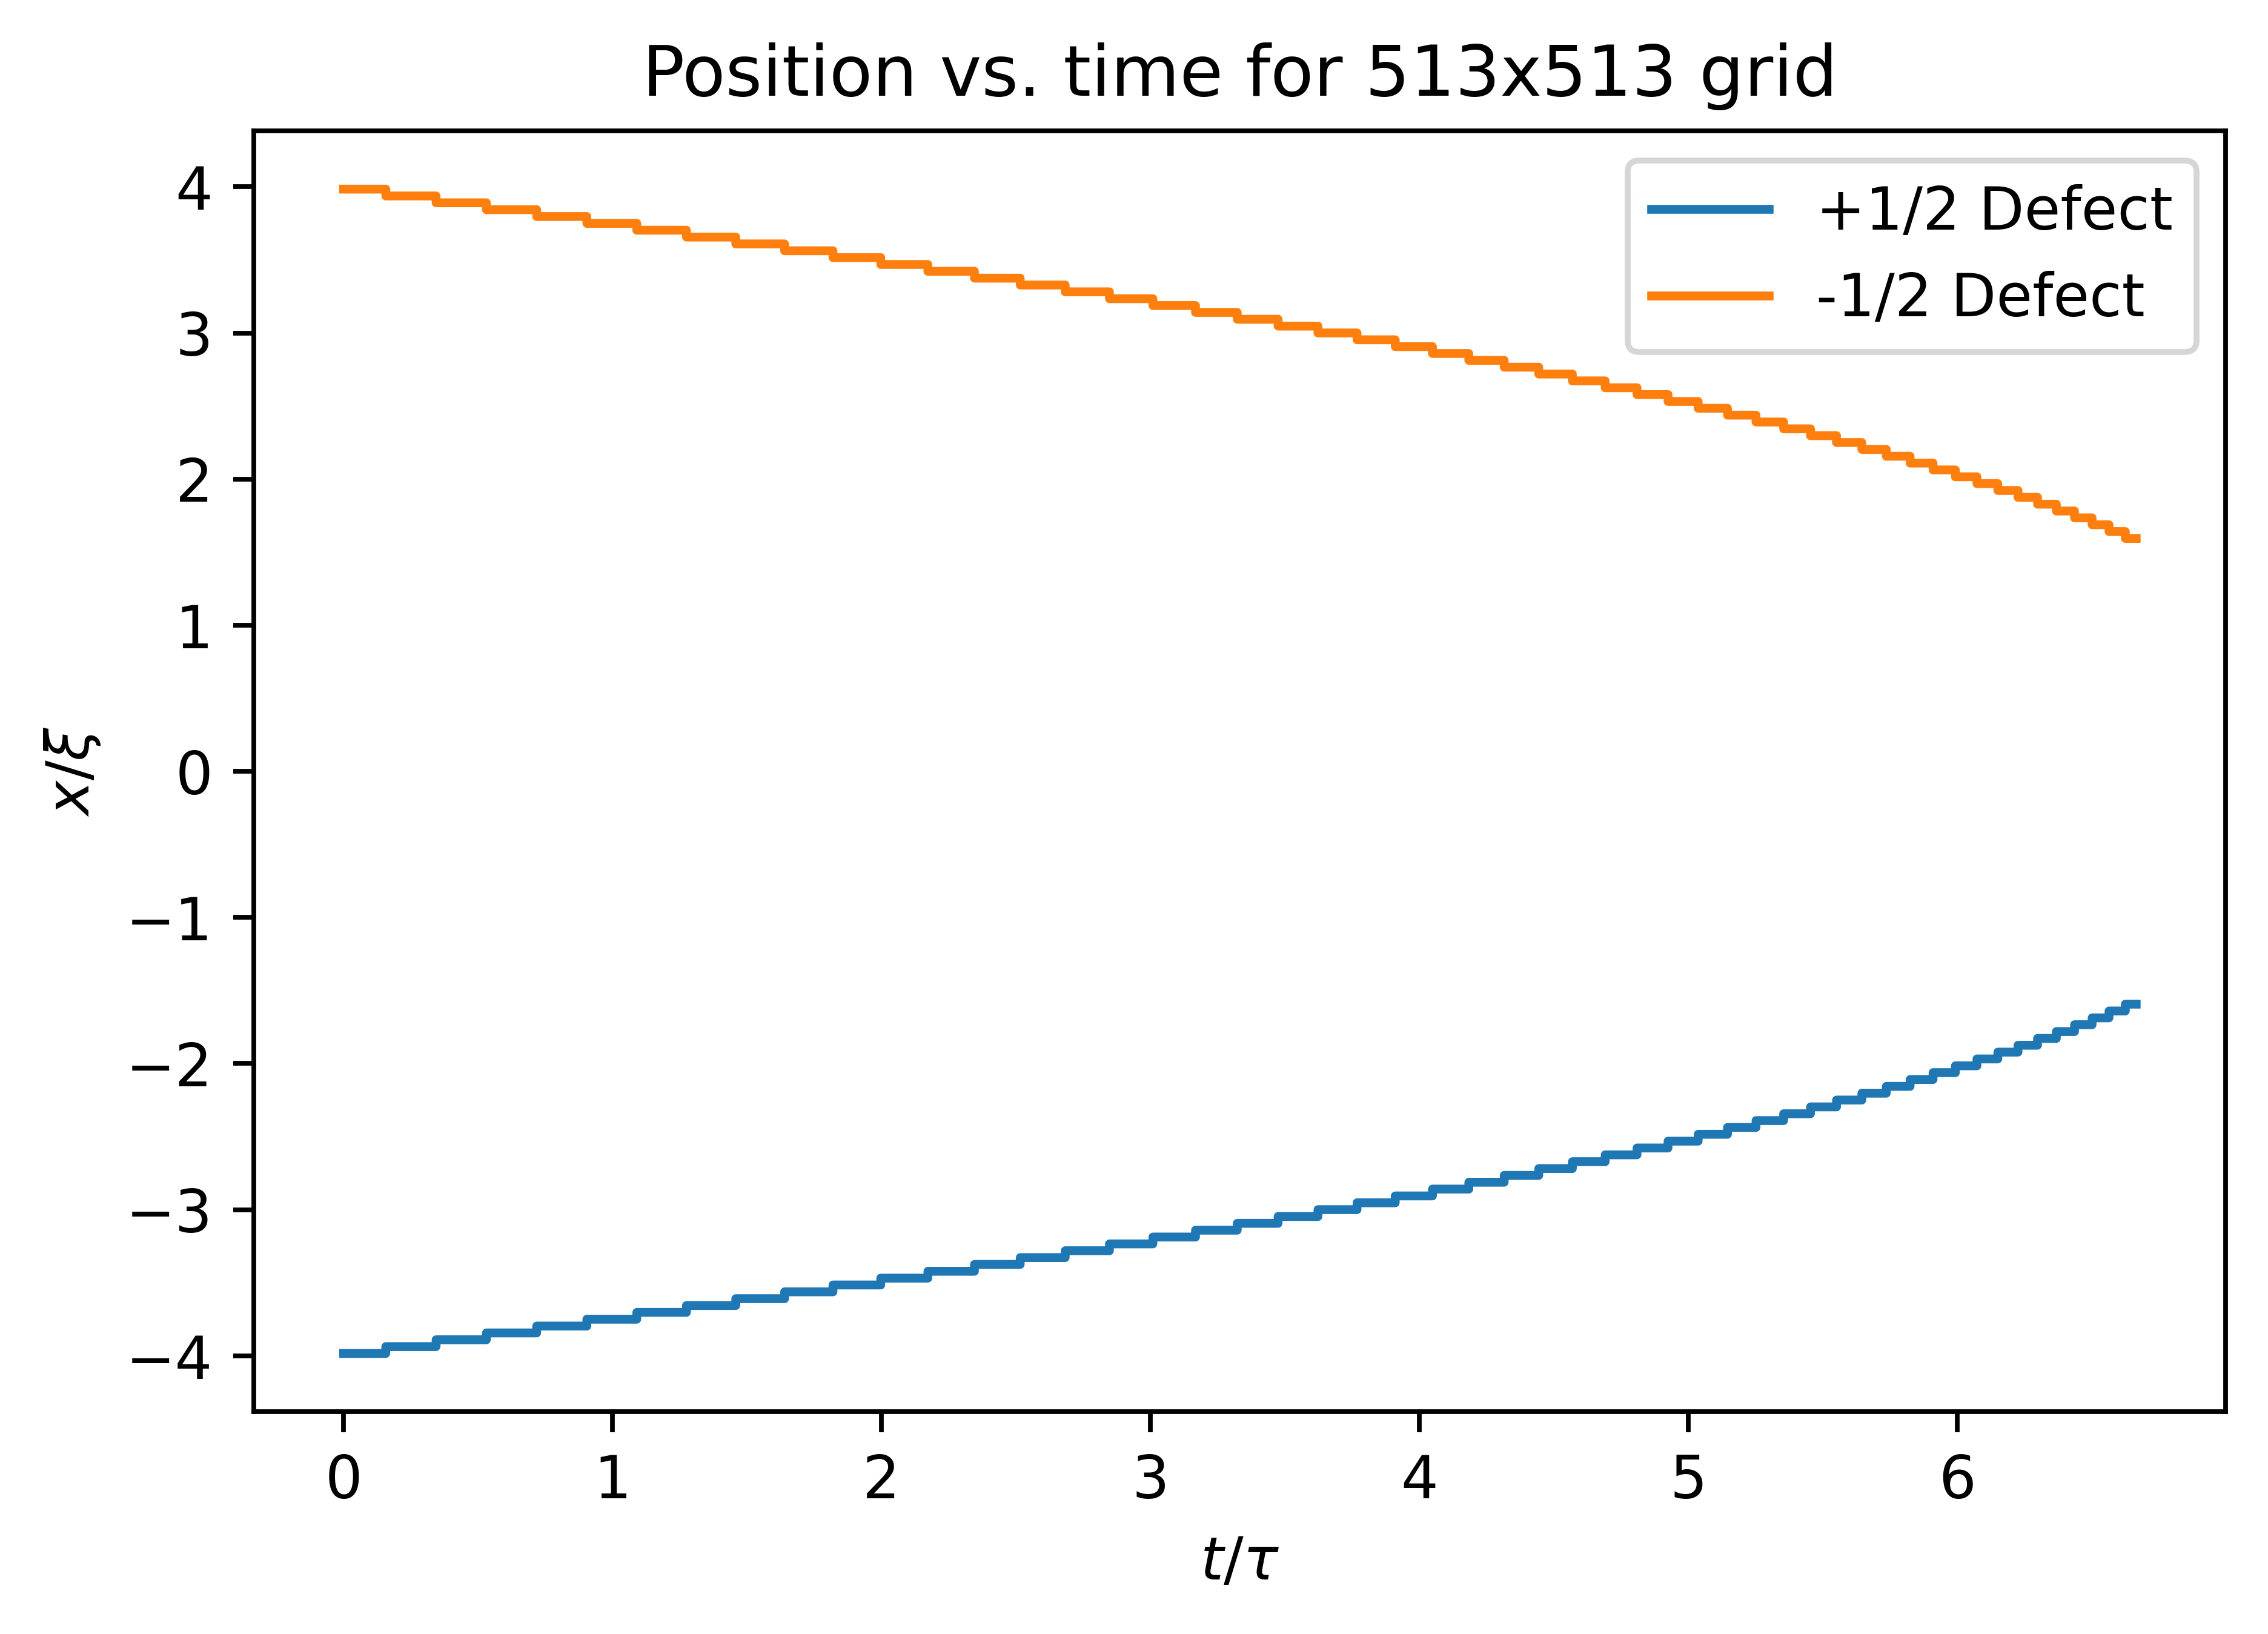

In [18]:
plt.plot(t[:], peak_pos[0, :], label='+1/2 Defect')
plt.plot(t[:], peak_pos[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 513x513 grid')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-513pts-double-defect-spacing.png')
plt.savefig(filename_defect_pos_vs_time)

### The defects don't annihilate when we think they will. Let's try sparser spacing in a different script